# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, 3-level
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [1]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy
import itertools

In [2]:
### Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge" #"plain"
weighted = False #True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513015


## Level 0->1 Coarsening

In [3]:
#kh = 0

# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

# Save null-space vectors so we dan orthogonalize error vectors to them.
num_eigenvectors = 10
z, lam = hm.analysis.ideal.ideal_tv(level.a, num_eigenvectors)
ind = (np.abs(lam[:num_eigenvectors]) < 1e-6)
z = z[:, ind]
z = hm.linalg.gram_schmidt(z)

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.269e+00                    4.470e-01    2.840
INFO     1     7.058e-01 (0.556) [0.556]    3.500e-01    2.021 (0.711)
INFO     2     4.121e-01 (0.585) [0.570]    3.045e-01    1.359 (0.672)
INFO     3     2.616e-01 (0.635) [0.591]    2.807e-01    0.938 (0.690)
INFO     4     1.830e-01 (0.699) [0.617]    2.662e-01    0.692 (0.738)
INFO     5     1.405e-01 (0.768) [0.645]    2.561e-01    0.553 (0.798)
INFO     6     1.154e-01 (0.821) [0.671]    2.484e-01    0.468 (0.846)
INFO     7     9.939e-02 (0.861) [0.695]    2.422e-01    0.414 (0.883)
INFO     8     8.840e-02 (0.889) [0.717]    2.369e-01    0.376 (0.909)
INFO     9     8.008e-02 (0.905) [0.736]    2.324e-01    0.347 (0.923)
INFO     10    7.360e-02 (0.918) [0.752]    2.283e-01    0.324 (0.935)
INFO     11    6.843e-02 (0.929) [0.767]    2.247e-01    0.306 (0.944)
INFO     12    6.421e-02 (0.938) [0.780]    2.214e-01    0.291 (0.952)
INFO 

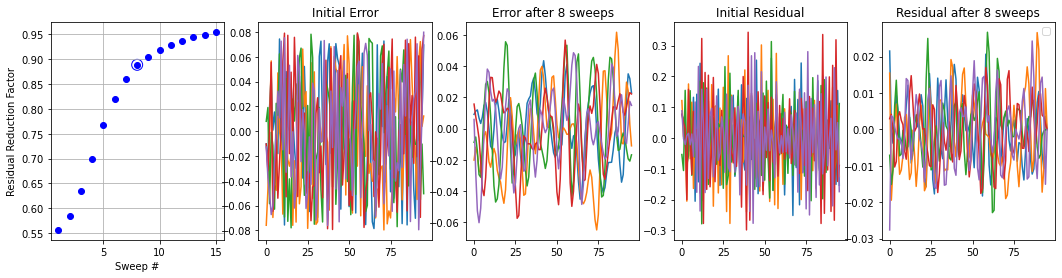

In [4]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["relax"][1]

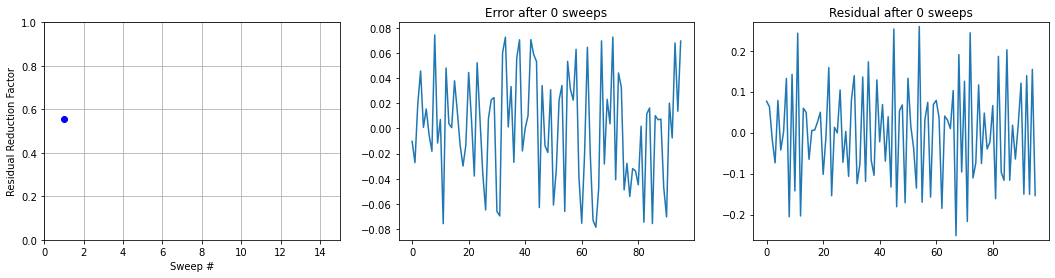

In [5]:
# Generate animation video of Kaczmarz shrinkage.
factor, num_sweeps, residual, conv, rer, relax_conv_factor, x_history, r_history = method_info["relax"]

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

fig, axs = plt.subplots(1, 3, figsize=(18, 4))
duration = 3
num_frames = len(r_history)
meshsize = duration / num_frames
#print(duration, num_frames, meshsize)

def make_frame(t):
    i = min(int(np.round(t / meshsize)), len(r_history)-1)
    ax = axs[0]
    ax.clear()
    color = "blue"
    x_ticks = np.arange(1, len(conv) + 1)
    ax.set_ylim([0, 1])
    ax.set_xlim([0, len(conv)])
    ax.plot(x_ticks[:(i + 1)], conv[:(i + 1)], "o", color=color) #, label=r"{} $\mu = {:.2f}, i = {}$".format(title, factor, num_sweeps))
    if i >= num_sweeps:
        ax.scatter([num_sweeps], [conv[num_sweeps - 1]], 120, facecolors='none', edgecolors=color)
    ax.set_ylabel("Residual Reduction Factor")
    ax.set_xlabel("Sweep #")
    ax.grid(True)

    ax = axs[1]
    ax.clear()
    ax.plot(x_history[i][:, 0])
    x_init = x_history[0][:, 0]
    ax.set_ylim([min(x_init) - 0.01, max(x_init) + 0.01])
    ax.set_title("Error after {} sweeps".format(i))

    ax = axs[2]
    ax.clear()
    ax.plot(r_history[i][:, 0])
    r_init = r_history[0][:, 0]
    ax.set_ylim([min(r_init) - 0.01, max(r_init) + 0.01])
    ax.set_title("Residual after {} sweeps".format(i))

    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
#animation.ipython_display(fps=10, loop=True, autoplay=True)
#animation.write_videofile("laplace_shrinkage.mp4", fps=num_frames // duration)
#animation.write_gif('kaczmarz_shrinkage.gif', fps=num_frames // duration)

In [6]:
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
print("kh", kh)

# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

kh 0.5233853805513012


INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.239e+00                    4.469e-01    2.775
INFO     1     7.015e-01 (0.566) [0.566]    3.514e-01    2.002 (0.721)
INFO     2     4.137e-01 (0.590) [0.578]    3.063e-01    1.357 (0.678)
INFO     3     2.586e-01 (0.626) [0.594]    2.831e-01    0.919 (0.677)
INFO     4     1.786e-01 (0.691) [0.617]    2.696e-01    0.667 (0.726)
INFO     5     1.359e-01 (0.761) [0.643]    2.603e-01    0.526 (0.788)
INFO     6     1.114e-01 (0.819) [0.670]    2.533e-01    0.442 (0.842)
INFO     7     9.643e-02 (0.864) [0.695]    2.475e-01    0.391 (0.885)
INFO     8     8.616e-02 (0.893) [0.717]    2.426e-01    0.357 (0.911)
INFO     9     7.854e-02 (0.911) [0.736]    2.382e-01    0.331 (0.928)
INFO     10    7.285e-02 (0.927) [0.753]    2.343e-01    0.312 (0.943)
INFO     11    6.842e-02 (0.939) [0.769]    2.307e-01    0.297 (0.953)
INFO     12    6.482e-02 (0.947) [0.782]    2.274e-01    0.286 (0.961)
INFO 

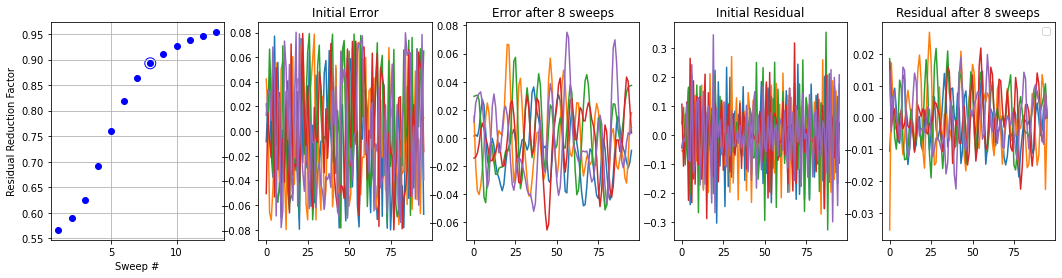

In [7]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["relax"][1]

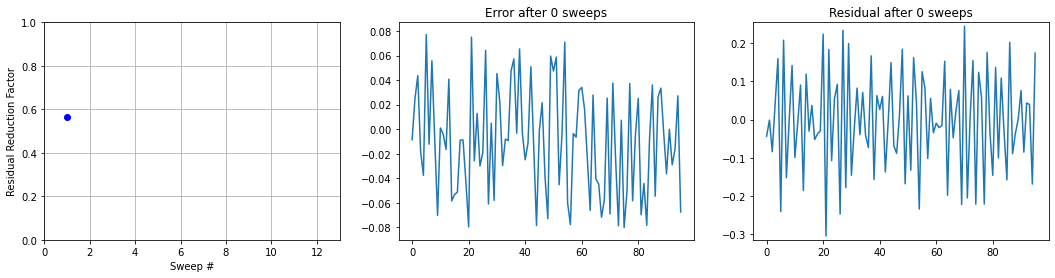

In [8]:
# Generate animation video of Kaczmarz shrinkage.

factor, num_sweeps, residual, conv, rer, relax_conv_factor, x_history, r_history = method_info["relax"]

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

fig, axs = plt.subplots(1, 3, figsize=(18, 4))
duration = 3
num_frames = len(r_history)
meshsize = duration / num_frames
#print(duration, num_frames, meshsize)

def make_frame(t):
    i = min(int(np.round(t / meshsize)), len(r_history)-1)
    ax = axs[0]
    ax.clear()
    color = "blue"
    x_ticks = np.arange(1, len(conv) + 1)
    ax.set_ylim([0, 1])
    ax.set_xlim([0, len(conv)])
    ax.plot(x_ticks[:(i + 1)], conv[:(i + 1)], "o", color=color) #, label=r"{} $\mu = {:.2f}, i = {}$".format(title, factor, num_sweeps))
    if i >= num_sweeps:
        ax.scatter([num_sweeps], [conv[num_sweeps - 1]], 120, facecolors='none', edgecolors=color)
    ax.set_ylabel("Residual Reduction Factor")
    ax.set_xlabel("Sweep #")
    ax.grid(True)

    ax = axs[1]
    ax.clear()
    ax.plot(x_history[i][:, 0])
    x_init = x_history[0][:, 0]
    ax.set_ylim([min(x_init) - 0.01, max(x_init) + 0.01])
    ax.set_title("Error after {} sweeps".format(i))

    ax = axs[2]
    ax.clear()
    ax.plot(r_history[i][:, 0])
    r_init = r_history[0][:, 0]
    ax.set_ylim([min(r_init) - 0.01, max(r_init) + 0.01])
    ax.set_title("Residual after {} sweeps".format(i))

    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
#animation.ipython_display(fps=10, loop=True, autoplay=True)
#animation.write_videofile("kaczmarz_shrinkage.mp4", fps=num_frames // duration)
#animation.write_gif('kaczmarz_shrinkage.gif', fps=num_frames // duration)

In [9]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 4 TVs with 8 sweeps
INFO     RER 0.390


### Coarsening: Fixed (4/2)

In [10]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

nu  30 s [1.    0.624 0.092 0.013] Energy error [0.533 0.078 0.011 0.   ]
INFO     Mock cycle conv [0.597 0.328 0.199 0.153 0.149 0.126 0.087 0.072 0.069 0.064 0.062]


array([[-0.409, -0.538, -0.565, -0.473],
       [-0.7  , -0.265,  0.243,  0.617]])

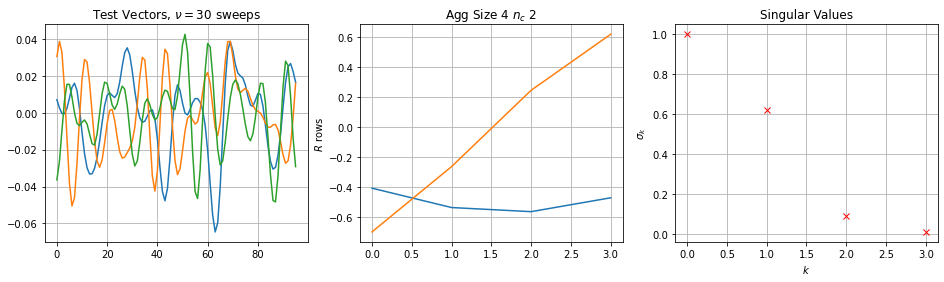

In [11]:
helmholtz.analysis.plots.plot_svd_coarsening_accuracy(level, 30, aggregate_size, num_components)

,0,1,2,3,4,5,6,7,8,9
0,0.3940,0.5741,0.5921,0.4057,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.6450,-0.2874,0.2554,0.6604,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.3940,0.5741,0.5921,0.4057,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,-0.6450,-0.2874,0.2554,0.6604,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3940,0.5741


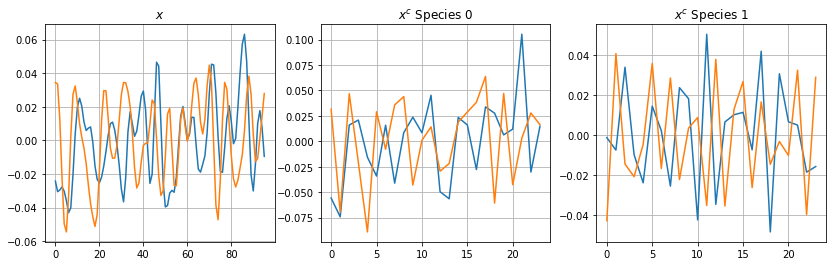

In [12]:
aggregate_size, num_components = 4, 2
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Two-level Rates
Calculated with 100 relaxations on the coarse level.

In [13]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
aggregate_size = 4
num_components = 2
nu_coarsest = -1 # -1
m = None #8

coarsening_types = [
    ("P^T A P caliber 2", 2, "pt"),
    ("P^T A P caliber 3", 3, "pt"),
    ("P^T A P caliber 4", 4, "pt"),
    ("Q A P caliber 4", 4, "q"),
    ("R A P caliber 4", 4, "r"),
]

all_conv, r, p_caliber, q = helmholtz.analysis.stats.compare_coarsening(level, coarsening_types, nu, 
                       domain_size,
                       aggregate_size, num_components,
                       ideal_tv=ideal_tv,
                       num_examples=num_examples,
                       nu_coarsest=nu_coarsest,
                       interpolation_method=interpolation_method,
                       fit_scheme=fit_scheme,
                       weighted=weighted,
                       neighborhood=neighborhood,
                       repetitive=repetitive,
                       m=m)

styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

INFO     Generating 4 TVs with 8 sweeps
INFO     RER 0.359


,Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,0.6118,0.3147,0.1877,0.1388,0.1441,0.1275,0.0841,0.0622,0.0557,0.0504,0.0462
P^T A P caliber 2,1.2000,0.0000,0.5027,0.3508,0.3825,0.4089,0.3762,0.3832,0.3382,0.3411,0.3235,0.3263,0.3139
P^T A P caliber 3,1.4000,0.0000,0.6826,0.4244,0.2476,0.3190,0.2557,0.2475,0.2704,0.2652,0.2808,0.2935,0.2988
P^T A P caliber 4,2.0000,0.0000,0.6043,0.3429,0.2270,0.1754,0.1447,0.1678,0.1337,0.1019,0.1211,0.1206,0.1179
Q A P caliber 4,1.2000,0.0000,1.1720,0.5498,0.3680,0.1875,0.2119,0.1669,0.1275,0.1167,0.1330,0.1286,0.1231
R A P caliber 4,1.2000,0.0199,0.9894,0.5124,0.3105,0.2437,0.2551,0.2286,0.1919,0.1543,0.1210,0.0936,0.0765


* The SVD intepolation is good up to $\nu = 2$, conv $\approx 0.36$. This is similar to the case of Laplace + 2/1 coarsening, where $P$ is only first-order.
* Caliber 2 is equivalent to $P = R^T$.
* Caliber 3 is insufficient, oonly gives marginally better convergence than $P = R^T$.
* Caliber 4 Galerkin gives ideal rates (up to $0.11$).
* Caliber 4 $P$ with $R A P$ is slightly non-symmetric but sparser than $P^T A P$. It gives an intermediate performance between $R A R^R$ and $P^T A P$ (up to $0.18$). 

In [14]:
# for use_r_as_restriction in (False, True):

#     print("R*A*P" if use_r_as_restriction else "P^T*A*P")
#     for caliber in calibers:
#         p = p_caliber[caliber]
#         ml = hm.repetitive.locality.create_two_level_hierarchy(
#             kh, discretization, n, r, p, r if use_r_as_restriction else p.T, aggregate_size, num_components)
#         ac = ml[1].a
#         print("caliber {} P".format(caliber))
#         display(pd.DataFrame(p[:aggregate_size, np.unique(p[:aggregate_size].nonzero()[1])].todense()))
#         print("A^1")
#         display(pd.DataFrame(ac[:num_components, np.unique(ac[:num_components].nonzero()[1])].todense()))

In [15]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P.
p = p_caliber[4]

### Solving $Ax = b$ - Convergence History

#### $R A P$

INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      1.882e+01           2.243           8.390
INFO     1      1.850e+00  (0.098)  1.020  (0.455)  1.814
INFO     2      3.581e-01  (0.194)  0.263  (0.258)  1.359
INFO     3      1.063e-01  (0.297)  0.087  (0.332)  1.217
INFO     4      6.639e-02  (0.624)  0.058  (0.668)  1.137
INFO     5      5.109e-02  (0.769)  0.047  (0.806)  1.085
INFO     6      4.062e-02  (0.795)  0.039  (0.821)  1.051
INFO     7      3.262e-02  (0.803)  0.032  (0.821)  1.028
INFO     8      2.626e-02  (0.805)  0.026  (0.817)  1.013
INFO     9      2.117e-02  (0.806)  0.021  (0.814)  1.003
INFO     10     1.708e-02  (0.807)  0.017  (0.812)  0.997
INFO     11     1.379e-02  (0.807)  0.014  (0.811)  0.993
INFO     12     1.114e-02  (0.808)  0.011  (0.810)  0.990
INFO     13     9.013e-03  (0.809)  0.009  (0.810)  0.988
INFO     14     7.294e-03  (0.809)  0.007  (0.810)  0.987
INFO     15     5.908e-03  (0.810)  0.006  (0.811)  0.987
INFO     16  

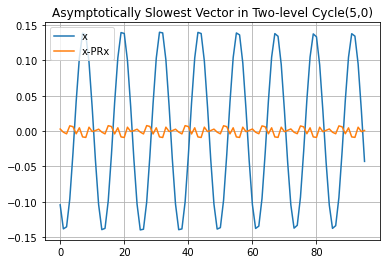

In [16]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 5

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, r, p, q, aggregate_size, num_components)

y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu, nu_post=0, nu_coarsest=5, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
y -= y.mean() # Remove zero component.
e = y - m0[1].interpolate(m0[1].coarsen(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [17]:
m0[0].size, m0[1].size

(96, 48)

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.284e+00                    4.471e-01    2.874
INFO     1     7.229e-01 (0.564) [0.564]    3.451e-01    2.099 (0.730)
INFO     2     4.256e-01 (0.589) [0.576]    2.965e-01    1.439 (0.686)
INFO     3     2.677e-01 (0.629) [0.593]    2.715e-01    0.989 (0.687)
INFO     4     1.846e-01 (0.689) [0.616]    2.568e-01    0.720 (0.729)
INFO     5     1.395e-01 (0.755) [0.642]    2.469e-01    0.566 (0.785)
INFO     6     1.127e-01 (0.807) [0.667]    2.395e-01    0.471 (0.832)
INFO     7     9.592e-02 (0.850) [0.691]    2.336e-01    0.412 (0.872)
INFO     8     8.469e-02 (0.882) [0.712]    2.287e-01    0.371 (0.901)
INFO     9     7.666e-02 (0.905) [0.732]    2.244e-01    0.343 (0.922)
INFO     10    7.064e-02 (0.922) [0.749]    2.206e-01    0.321 (0.938)
INFO     11    6.584e-02 (0.932) [0.764]    2.172e-01    0.304 (0.947)
INFO     12    6.195e-02 (0.941) [0.777]    2.141e-01    0.291 (0.955)
INFO 

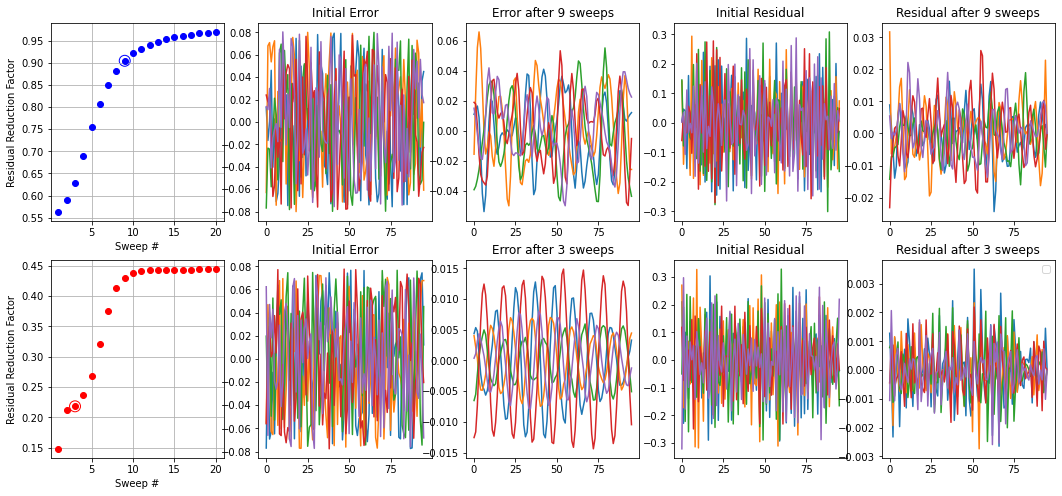

In [18]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m0, num_levels=2, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20,
    nu_pre=2, nu_post=2, nu_coarsest=20)

In [19]:

m0[1].size

48

In [20]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", np.array2string(lam[:12], precision=3))

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [-0.007 -0.007  0.061  0.061 -0.085 -0.085  0.119  0.119  0.166  0.166 -0.169 -0.169]


In [21]:
pd.set_option("display.precision", 8)
pd.DataFrame(m0[0].a.todense()[2:4, :6])

,0,1,2,3,4,5
0,-0.0833,1.3333,-2.2261,1.3333,-0.0833,0.0000
1,0.0000,-0.0833,1.3333,-2.2261,1.3333,-0.0833


In [22]:
pd.set_option("display.precision", 3)
pd.DataFrame(m0[1].a.todense()[2:4, :6])

,0,1,2,3,4,5
0,0.1517,0.1912,-0.0428,0.0334,0.1517,-0.1616
1,-0.1616,-0.1504,0.0334,-0.6582,0.1912,-0.1504


In [23]:
pd.DataFrame((m0[1].a - m0[1].a.transpose()).todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000
5,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000
7,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000


## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [24]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

num_sweeps_on_vectors = None # 100

## Level 1 Relaxation

We run relaxation on $A x = 0$. $A$ has two null vectors; call $Y$ the $n \times 2$ matrix whose columns are these vectors. Let $x_0$ be a random[-1, 1] initial guess for $x$. We first project $x_0$ onto the range of $A$, that is,

$x_0 \longleftarrow x_0 - Y Y^T x_0^T\,,$

and use this as the initial guess for the run. Since the magnitude of $Y$ the exact solution is $0$, and relaxation doesn't change this magnitude, $e = x - x_0$ is a meaningful definition, which can also be used to calculate a meaningful RER.

In [25]:
m1 = m0.sub_hierarchy(1)
level = m1.finest_level
a = level.a

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.475e-01                    4.455e-01    0.556
INFO     1     9.955e-02 (0.401) [0.401]    2.718e-01    0.365 (0.659)
INFO     2     4.876e-02 (0.492) [0.445]    2.110e-01    0.230 (0.635)
INFO     3     2.986e-02 (0.622) [0.496]    1.844e-01    0.164 (0.715)
INFO     4     2.268e-02 (0.771) [0.552]    1.684e-01    0.139 (0.847)
INFO     5     1.806e-02 (0.802) [0.594]    1.574e-01    0.119 (0.862)
INFO     6     1.529e-02 (0.848) [0.630]    1.496e-01    0.107 (0.896)
INFO     7     1.336e-02 (0.872) [0.660]    1.436e-01    0.098 (0.913)
INFO     8     1.191e-02 (0.889) [0.685]    1.387e-01    0.091 (0.924)
INFO     9     1.076e-02 (0.900) [0.707]    1.346e-01    0.085 (0.930)
INFO     10    9.812e-03 (0.908) [0.725]    1.311e-01    0.080 (0.935)
INFO     11    9.025e-03 (0.915) [0.741]    1.280e-01    0.075 (0.940)
INFO     12    8.361e-03 (0.922) [0.755]    1.253e-01    0.071 (0.944)
INFO 

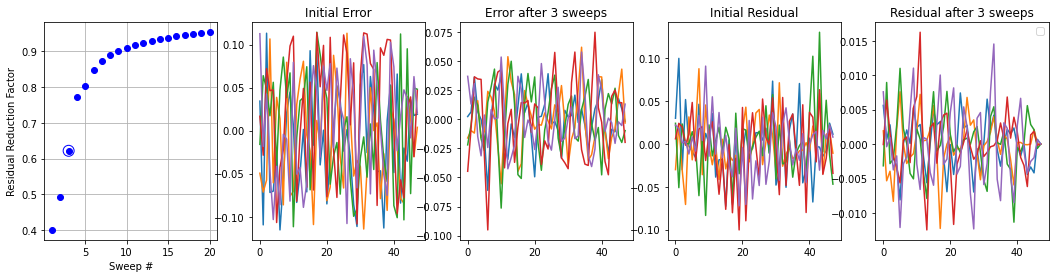

In [26]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["relax"][1]

nu 100 s [1.    0.798 0.011 0.002] Energy error [0.624 0.009 0.001 0.   ]
INFO     Mock cycle conv [0.29  0.168 0.142 0.13  0.105 0.096 0.081 0.07  0.058 0.05  0.038]


array([[-0.681,  0.19 ,  0.647,  0.285],
       [ 0.444,  0.552,  0.517, -0.481]])

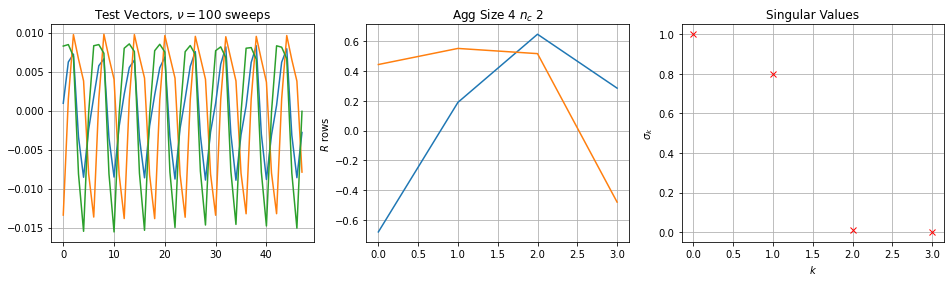

In [27]:
# #PCs revealed by relaxed vectors of increasing smoothness.
helmholtz.analysis.plots.plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

In [28]:
pd.DataFrame(level.a.todense()[10:12, 8:14])

,0,1,2,3,4,5
0,0.1517,0.1912,-0.0428,0.0334,0.1517,-0.1616
1,-0.1616,-0.1504,0.0334,-0.6582,0.1912,-0.1504


In [29]:
ideal_tv = False # True
num_examples = 5
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else 2 * num_sweeps
# Generate initial test vectors.
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 5 TVs with 6 sweeps
INFO     RER 0.082


[1.    0.823 0.218 0.028]
(24, 48)


,0,1,2,3,4,5,6,7,8,9
0,0.6056,-0.2460,-0.7250,-0.2172,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.5567,0.4877,0.4494,-0.5002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.6056,-0.2460,-0.7250,-0.2172,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.5567,0.4877,0.4494,-0.5002,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6056,-0.2460


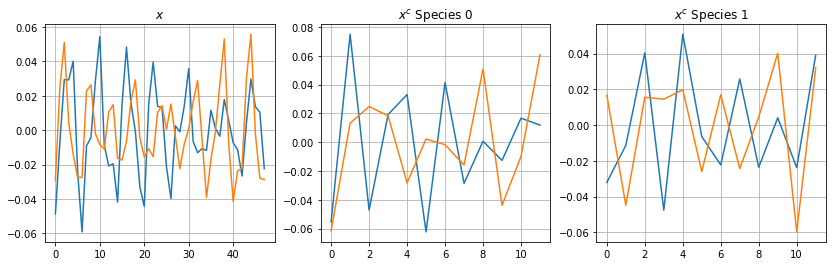

In [30]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
print(s/s[0])
R = r.tile(level.size // aggregate_size)
print(R.shape)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Two-level Rates
Calculated with an exact solver on the coarse level.

In [31]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
aggregate_size = 4
num_components = 2
nu_coarsest = -1 # 100
m = None #8

coarsening_types = [
    ("P^T A P caliber 2", 2, "pt"),
    ("P^T A P caliber 3", 3, "pt"),
    ("P^T A P caliber 4", 4, "pt"),
    ("Q A P caliber 4", 4, "q"),
    ("R A P caliber 4", 4, "r"),
]

all_conv, r, p_caliber, q = helmholtz.analysis.stats.compare_coarsening(level, coarsening_types, nu, 
                       domain_size,
                       aggregate_size, num_components,
                       ideal_tv=ideal_tv,
                       num_examples=num_examples,
                       nu_coarsest=nu_coarsest,
                       interpolation_method=interpolation_method,
                       fit_scheme=fit_scheme,
                       weighted=weighted,
                       neighborhood=neighborhood,
                       repetitive=repetitive,
                       m=m)

styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

INFO     Generating 5 TVs with 3 sweeps
INFO     RER 0.183


,Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,0.4350,0.2459,0.1310,0.1162,0.1017,0.0863,0.0799,0.0793,0.0677,0.0739,0.0700
P^T A P caliber 2,1.0000,0.0000,4.6207,3.1021,2.7762,2.7292,2.4640,2.2051,2.0109,1.8819,1.7944,1.6924,1.6040
P^T A P caliber 3,1.1667,0.0000,2.6857,2.0009,1.7716,1.5425,1.3349,1.1592,1.0045,0.8702,0.7531,0.6509,0.5604
P^T A P caliber 4,1.6667,0.0000,0.9351,0.5780,0.6363,0.6595,0.7118,0.7145,0.7248,0.7246,0.7270,0.7257,0.7188
Q A P caliber 4,1.0000,0.0000,1.7798,1.4292,0.7457,0.6360,0.6280,0.6199,0.6159,0.6092,0.6238,0.6233,0.6071
R A P caliber 4,1.0000,0.0232,7.5312,7.1977,3.0636,0.7866,0.5975,0.6011,0.5927,0.5944,0.6322,0.6147,0.6170


Now, calculate the rates with 100 relaxations at the coarse level.

In [32]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else 2 * num_sweeps
aggregate_size = 4
num_components = 2
nu_coarsest = -1 # 10
m = None #8

coarsening_types = [
    ("P^T A P caliber 2", 2, "pt"),
    ("P^T A P caliber 3", 3, "pt"),
    ("P^T A P caliber 4", 4, "pt"),
    ("Q A P caliber 4", 4, "q"),
    ("R A P caliber 4", 4, "r"),
]

all_conv, r, p_caliber, q = helmholtz.analysis.stats.compare_coarsening(level, coarsening_types, nu, 
                       domain_size,
                       aggregate_size, num_components,
                       ideal_tv=ideal_tv,
                       num_examples=num_examples,
                       nu_coarsest=nu_coarsest,
                       interpolation_method=interpolation_method,
                       fit_scheme=fit_scheme,
                       weighted=weighted,
                       neighborhood=neighborhood,
                       repetitive=repetitive,
                       m=m)

styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

INFO     Generating 5 TVs with 6 sweeps
INFO     RER 0.131


,Fill-in,Symmetry,1,2,3,4,5,6,7,8,9,10,11
Mock,nan,nan,0.3135,0.2655,0.2118,0.1879,0.1618,0.1154,0.1184,0.0997,0.0837,0.0685,0.0561
P^T A P caliber 2,1.0000,0.0000,4.0765,1.7647,1.5800,1.3266,1.4743,1.6243,1.7712,1.8200,1.7607,1.7700,1.8186
P^T A P caliber 3,1.1667,0.0000,5.0329,3.0790,2.6043,2.2625,2.0139,1.8279,1.5921,1.4605,1.3729,1.4130,1.2234
P^T A P caliber 4,1.6667,0.0000,0.7433,0.4312,0.2118,0.0783,0.0563,0.0426,0.0382,0.0343,0.0284,0.0234,0.0239
Q A P caliber 4,1.0000,0.0000,5.8991,2.9784,0.6860,0.5988,0.5197,0.3363,0.2405,0.1826,0.1358,0.0926,0.1021
R A P caliber 4,1.0000,0.0113,3.2474,1.6757,0.4154,0.3328,0.2922,0.1758,0.1371,0.0919,0.0805,0.0838,0.0909


### Solving $Ax = b$ - Convergence History
If we don't solve exactly at the coarsest level, the cycle stalls.

INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      3.297e+00           0.578           5.709
INFO     1      7.061e-01  (0.214)  0.463  (0.801)  1.525
INFO     2      7.791e-02  (0.110)  0.210  (0.453)  0.372
INFO     3      1.636e-02  (0.210)  0.093  (0.442)  0.177
INFO     4      3.839e-03  (0.235)  0.043  (0.459)  0.090
INFO     5      1.515e-03  (0.395)  0.032  (0.763)  0.047
INFO     6      8.292e-04  (0.547)  0.034  (1.058)  0.024
INFO     7      4.723e-04  (0.570)  0.038  (1.100)  0.013
INFO     8      2.644e-04  (0.560)  0.041  (1.080)  0.006
INFO     9      1.441e-04  (0.545)  0.043  (1.049)  0.003
INFO     10     7.646e-05  (0.531)  0.044  (1.019)  0.002
INFO     11     3.951e-05  (0.517)  0.043  (0.990)  0.001
INFO     12     1.988e-05  (0.503)  0.042  (0.963)  0.000
INFO     13     9.738e-06  (0.490)  0.039  (0.936)  0.000
INFO     14     4.635e-06  (0.476)  0.035  (0.909)  0.000
INFO     15     2.142e-06  (0.462)  0.031  (0.883)  0.000
INFO     16  

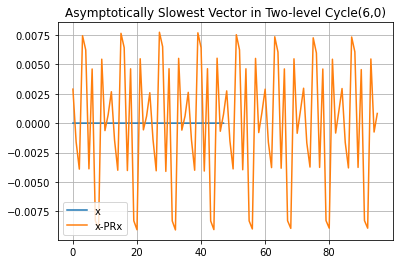

In [33]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 6
p = p_caliber[4] # P^T*A*P P high order

m1 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, q, aggregate_size, num_components)

y, _ = hm.repetitive.locality.two_level_conv_factor(m1, nu, print_frequency=1, nu_coarsest=100,
                                                    debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

### Level 2 relaxation shrinkage
Relaxation does converge.

Finest level 24
INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     5.297e-02                    4.465e-01    0.120
INFO     1     1.804e-02 (0.354) [0.354]    3.145e-01    0.058 (0.501)
INFO     2     1.121e-02 (0.624) [0.469]    2.805e-01    0.042 (0.709)
INFO     3     8.095e-03 (0.727) [0.542]    2.617e-01    0.033 (0.786)
INFO     4     6.172e-03 (0.764) [0.590]    2.499e-01    0.027 (0.805)
INFO     5     4.992e-03 (0.809) [0.629]    2.417e-01    0.022 (0.841)
INFO     6     4.219e-03 (0.845) [0.660]    2.358e-01    0.019 (0.870)
INFO     7     3.693e-03 (0.875) [0.688]    2.311e-01    0.017 (0.895)
INFO     8     3.326e-03 (0.901) [0.711]    2.274e-01    0.016 (0.918)
INFO     9     3.059e-03 (0.920) [0.732]    2.242e-01    0.015 (0.934)
INFO     10    2.856e-03 (0.934) [0.750]    2.215e-01    0.014 (0.947)
INFO     11    2.697e-03 (0.944) [0.766]    2.191e-01    0.013 (0.956)
INFO     12    2.571e-03 (0.953) [0.780]    2.169e-01    0.0

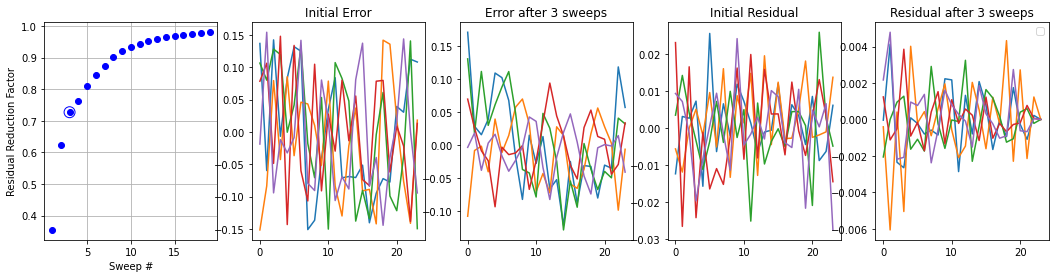

In [34]:
m2 = m1.sub_hierarchy(1)
print("Finest level", m2[0].size)
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m2, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["relax"][1]

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.595e-01                    4.460e-01    0.584
INFO     1     1.094e-01 (0.422) [0.422]    2.620e-01    0.424 (0.728)
INFO     2     5.310e-02 (0.488) [0.453]    1.853e-01    0.294 (0.696)
INFO     3     3.111e-02 (0.587) [0.494]    1.541e-01    0.211 (0.714)
INFO     4     2.229e-02 (0.716) [0.542]    1.365e-01    0.173 (0.817)
INFO     5     1.715e-02 (0.766) [0.582]    1.256e-01    0.146 (0.840)
INFO     6     1.392e-02 (0.804) [0.616]    1.182e-01    0.125 (0.861)
INFO     7     1.169e-02 (0.832) [0.644]    1.128e-01    0.110 (0.876)
INFO     8     1.011e-02 (0.857) [0.668]    1.087e-01    0.098 (0.894)
INFO     9     8.980e-03 (0.881) [0.690]    1.053e-01    0.090 (0.912)
INFO     10    8.138e-03 (0.900) [0.709]    1.024e-01    0.084 (0.928)
INFO     Relax conv 0.90 shrinkage 0.54 PODR RER 0.17 after 4 sweeps. Work 1.0 eff 0.54
INFO     2-level MiniCycle
INFO     Iter     |r|           

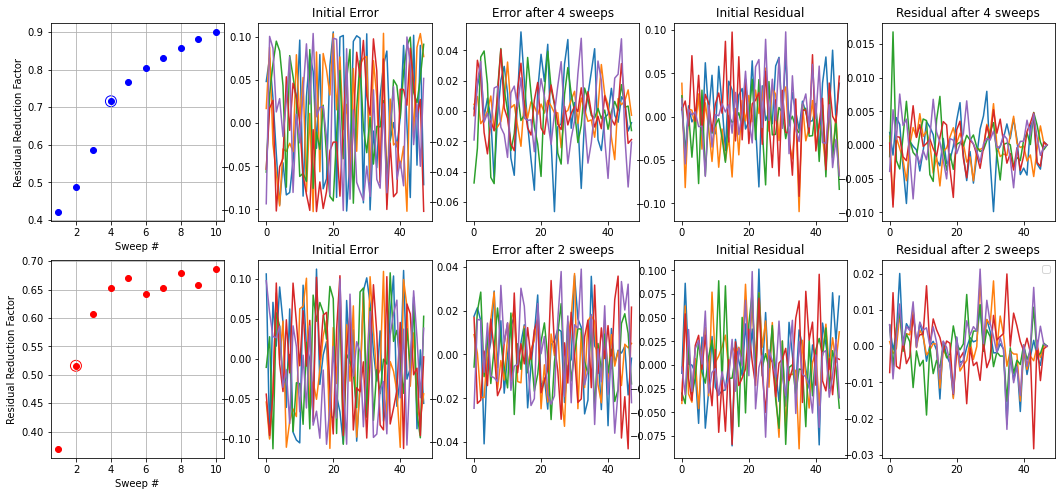

In [35]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=2, leeway_factor=leeway_factor, slow_conv_factor=1.3, max_sweeps=10,
    nu_pre=1, nu_post=1, nu_coarsest=10)

In [36]:
pd.DataFrame(m1[1]._r.todense()[:2, :4])

,0,1,2,3
0,0.6056,-0.2460,-0.7250,-0.2172
1,0.5567,0.4877,0.4494,-0.5002


In [37]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m1)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12], lam[0])

0 lam [-0.007 -0.007  0.061  0.061 -0.085 -0.085  0.119  0.119  0.166  0.166 -0.169 -0.169] -0.00731606703519278
1 lam [-0.007 -0.007 -0.007 -0.007 -0.021  0.031  0.031  0.06   0.06   0.084  0.084  0.084] -0.0067264116590857025


## 3-Level Method
With $Q A P$ coarsening at level $0$ and $R A P$ at leve1 1.

In [38]:
ml = hm.setup.hierarchy.multilevel.Multilevel.create(m0[0])
ml.add(m0[1])
ml.add(m1[1])

In [39]:
nu_pre = 5
nu_post = 2
y, _ = hm.repetitive.locality.two_level_conv_factor(ml, nu_pre, nu_post=nu_post, print_frequency=1, debug=False,
                                                   nu_coarsest=20)

# Asymptotic vector.
#plt.title("Asymptotically Slowest Vector in Cycle({}, 0)".format(nu_pre, nu_post))
# # y -= y.mean() # Remove zero component.
# # e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
# plt.plot(y, label="x");
# plt.plot(e, label="x-PRx");
# plt.grid(True);
# plt.legend();

INFO     Iter   |r|        Factor   RER    Factor   |e|   
INFO     0      1.600e+01           1.892           8.458
INFO     1      8.143e-01  (0.051)  0.507  (0.268)  1.606
INFO     2      9.417e-02  (0.116)  0.069  (0.137)  1.360
INFO     3      1.021e-02  (0.108)  0.008  (0.109)  1.359
INFO     4      1.312e-03  (0.128)  0.001  (0.128)  1.359
INFO     5      1.690e-04  (0.129)  0.000  (0.129)  1.359
INFO     6      2.160e-05  (0.128)  0.000  (0.128)  1.359
INFO     7      2.705e-06  (0.125)  0.000  (0.125)  1.359
INFO     8      3.357e-07  (0.124)  0.000  (0.124)  1.359
INFO     9      4.182e-08  (0.125)  0.000  (0.125)  1.359
INFO     10     5.295e-09  (0.127)  0.000  (0.127)  1.359
INFO     11     6.692e-10  (0.126)  0.000  (0.126)  1.359
INFO     12     8.492e-11  (0.127)  0.000  (0.127)  1.359


In [40]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(ml)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:21])

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167  0.205  0.205  0.235  0.235 -0.243 -0.243  0.257  0.257  0.27 ]
1 lam [-0.007 -0.007  0.061  0.061 -0.085 -0.085  0.119  0.119  0.166  0.166 -0.169 -0.169  0.203  0.203  0.231  0.231  0.249  0.249 -0.259 -0.259  0.26 ]
2 lam [-0.007 -0.007 -0.007 -0.007 -0.021  0.031  0.031  0.06   0.06   0.084  0.084  0.084 -0.1   -0.1    0.137  0.137  0.176  0.176  0.191 -0.193 -0.193]


In [41]:
# Save A^1 to file.
#scipy.sparse.save_npz('level_1_operator.npz', m0[1].a)

## What are the Coarse Variables?
Given level $l$ and some point $i$,  we look at $P^l P^{l-1} ... P^1 e^l_i$ wheer $e^l_i$ is the $i$th unit vector. There are two species ($i, i+1$) in our setup (4/2 coarsening at all levels). The following matix is level x species.

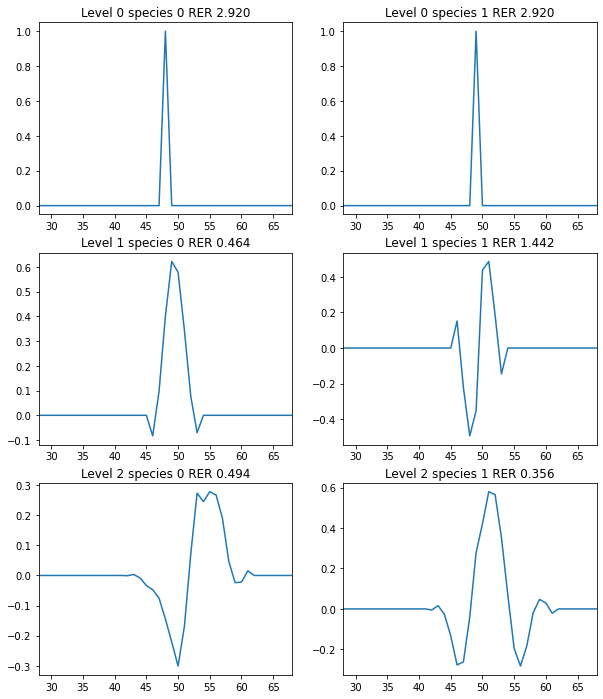

In [42]:
fig, axs = plt.subplots(len(ml), num_components, figsize=(10, 4 * len(ml)))

for l in range(len(ml)):
    m = ml[l].size
    i = m // 2
    for col, j in enumerate(range(i, i + num_components)):
        u = np.zeros((m,))
        u[j] = 1
        for ll in range(l, 0, -1):
            u = ml[ll]._p.dot(u)
        ax = axs[l, col]
        ax.set_title("Level {} species {} RER {:.3f}".format(l, col, norm(ml[0].operator(u)) / norm(u)))
        ax.plot(u);
        ax.set_xlim(ml[0].size // 2 - 20, ml[0].size // 2 + 20);

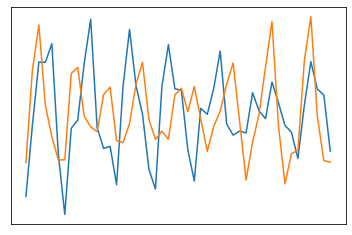

In [43]:
plt.plot(x[:, 0])
plt.plot(x[:, 1])
plt.xticks([], []);
plt.yticks([], []);
plt.savefig("tf.png")